### Cal-CRAI Metric Calculation for: Society & Economy / Health Shortage Metrics
This notebook calculates 3 metrics, all sourced from the California Health Resources and Services Administration.
* Mental health professional shortage area score
* Primary health care professional shortage area score
* num. of licensed narcotic treatment programs per 10,000 people

In [1]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, upload_csv_aws, filter_counties
from scripts.utils.write_metadata import append_metadata

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/society_economy/social_services/ca_health_human_services/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'society_hrsa_mental_care_shortage.gpkg' locally
Saved GeoPackage as 'society_hrsa_primary_care_shortage.gpkg' locally
Saved GeoPackage as 'society_hrsa_narcotic_support.gpkg' locally


In [3]:
mental_healthcare_shortage_data = gpd.read_file('society_hrsa_mental_care_shortage.gpkg')
primary_healthcare_shortage_data = gpd.read_file('society_hrsa_primary_care_shortage.gpkg')

mental_healthcare_shortage_data = mental_healthcare_shortage_data.to_crs(crs=4269) 
primary_healthcare_shortage_data = primary_healthcare_shortage_data.to_crs(crs=4269) 

os.remove('society_hrsa_mental_care_shortage.gpkg')
os.remove('society_hrsa_primary_care_shortage.gpkg')

Start with primary care shortage data

In [4]:
primary_healthcare_shortage_data

,objectid_1,HpsSrcID,HpsNM,HpsStatCD,HpsStatDes,HpsTypCD,HpsTypDes,HpsScore,MctaScore,HpsShtg,...,USCB_GEOID,USCB_NAME,USCB_NAMELSAD,USCB_MTFCC,USCB_FUNCSTAT,USCB_ALAND,USCB_AWATER,USCB_INTPTLAT,USCB_INTPTLON,geometry
0,540,1061107775,MENDOTA FAMILY HEALTH CENTER,D,Designated,RHC,Rural Health Clinic,16,20,0.00,...,06019008304,83.04,Census Tract 83.04,G5020,S,1277309433,3386618,+36.6262970,-120.5773805,POINT (-120.38213 36.75691)
1,662,1067581841,FCI - Mendota,D,Designated,PRSN,Correctional Facility,24,NA,0.84,...,06019008304,83.04,Census Tract 83.04,G5020,S,1277309433,3386618,+36.6262970,-120.5773805,POINT (-120.39234 36.73197)
2,541,1061111629,PRECISION HEALTH CENTER,D,Designated,FQHC LAL,Federally Qualified Health Center Look A Like,12,13,0.00,...,06037207102,2071.02,Census Tract 2071.02,G5020,S,415045,0,+34.0592851,-118.2395097,POINT (-118.24042 34.06099)
3,843,10699906KG,Chinatown Service Center,D,Designated,FQHC,Federally Qualified Health Center,17,17,0.00,...,06037207102,2071.02,Census Tract 2071.02,G5020,S,415045,0,+34.0592851,-118.2395097,POINT (-118.23971 34.06256)
4,542,1061135897,CLINICA AGUA VIVA,D,Designated,RHC,Rural Health Clinic,16,19,0.00,...,06107002601,26.01,Census Tract 26.01,G5020,S,5688638,0,+36.2136987,-119.1045232,POINT (-119.09612 36.21296)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,980,10699906ZS,REDWOOD MEDICAL CLINIC,D,Designated,RHC,Rural Health Clinic,14,17,0.00,...,06045010700,107,Census Tract 107,G5020,S,26178505,53812,+39.4224602,-123.3672722,POINT (-123.33934 39.38994)
439,981,10699906ZU,"Operation Samahan, Inc.",D,Designated,FQHC,Federally Qualified Health Center,18,16,0.00,...,06073011602,116.02,Census Tract 116.02,G5020,S,1005857,13822,+32.6599903,-117.0941732,POINT (-117.09204 32.66109)
440,982,10699906ZV,"Unicare Community Health Center, Inc.",D,Designated,FQHC,Federally Qualified Health Center,15,17,0.00,...,06071001400,14,Census Tract 14,G5020,S,1145117,0,+34.0668011,-117.6510112,POINT (-117.65218 34.06799)
441,983,10699906ZX,San Benito Health Foundation,D,Designated,FQHC,Federally Qualified Health Center,20,18,0.00,...,06069000300,3,Census Tract 3,G5020,S,6517209,0,+36.8617477,-121.4226066,POINT (-121.41701 36.85325)


<Axes: >

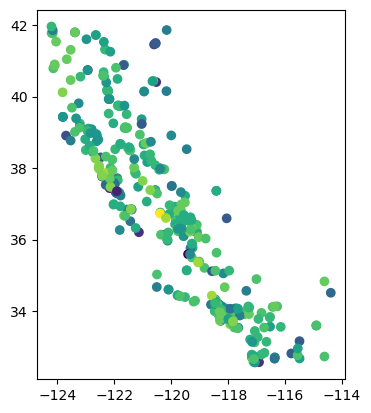

In [5]:
primary_healthcare_shortage_data.plot(column="HpsScore")

call in California 2021 tiger tract data

In [6]:
# read in CA census tiger file
tract_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"

ca_tract_boundaries = gpd.read_file(tract_shp_dir)
# need to rename columns so we don't have any duplicates in the final geodatabase
column_names = ca_tract_boundaries.columns
# new_column_names = ["USCB_"+column for column in column_names if column != "geometry"]
ca_tract_boundaries = ca_tract_boundaries.rename(columns={'GEOID':"TRACT"})
ca_tract_boundaries = ca_tract_boundaries.to_crs(crs=4269) 
ca_tract_boundaries

,STATEFP,COUNTYFP,TRACTCE,TRACT,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,059,001303,06059001303,13.03,Census Tract 13.03,G5020,S,1179647,0,+33.9209014,-117.9511671,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06,059,001304,06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06,013,367200,06013367200,3672,Census Tract 3672,G5020,S,1322255,0,+37.9660275,-122.3355517,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


sjoin instead and take a mean of all the point data within a tract

<Axes: >

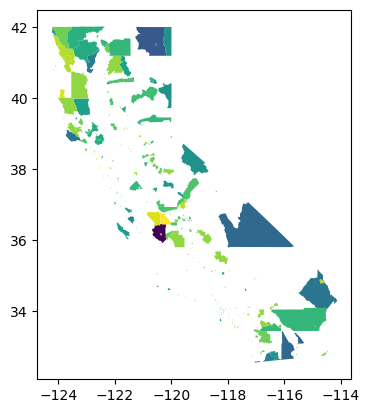

In [7]:
# sjoin with tracts
joined_primary_df = ca_tract_boundaries.sjoin(primary_healthcare_shortage_data).reset_index()
# take the mean of the point data within each tract
avg_primary_df = joined_primary_df.groupby('USCB_GEOID')['HpsScore'].agg(['mean']).reset_index()
# merge the means with the tract shapefile and transform to geodataframe so we can plot
avg_primary_df = avg_primary_df.rename(columns={"USCB_GEOID":"TRACT"})
avg_primary_df = pd.merge(avg_primary_df,ca_tract_boundaries,on="TRACT", how='right')
avg_primary_df = gpd.GeoDataFrame(avg_primary_df,geometry="geometry")
avg_primary_df.plot(column="mean")

isolate for relevant columns

In [8]:
columns_keep = ['TRACT', 'mean']

primary_healthcare_shortage_metric = avg_primary_df[columns_keep]
primary_healthcare_shortage_metric = primary_healthcare_shortage_metric.rename(columns={'TRACT':'census_tract', 'mean':'avg_hpsscore_primary_care_metric'})
primary_healthcare_shortage_metric

,census_tract,avg_hpsscore_primary_care_metric
0,06085504321,NaN
1,06085504410,NaN
2,06085507003,NaN
3,06085507004,NaN
4,06085502204,NaN
...,...,...
9124,06059001303,NaN
9125,06059001304,NaN
9126,06059001401,NaN
9127,06013367200,NaN


## Now to count the number of Indian Health Service designation types are in the primary healthcare shortage dataset
* per census tract
* then merge to our calculated metric dataframe based on tract

In [9]:
primary_native_tribe_column = joined_primary_df

columns_to_keep = ['TRACT', 'HpsTypDes']

native_tribe_merge = pd.merge(primary_native_tribe_column, ca_tract_boundaries,on="TRACT", how='right')
cleaned_native_tribe = native_tribe_merge.drop_duplicates(subset=['TRACT', 'HpsTypDes'])

filtered_df = cleaned_native_tribe[cleaned_native_tribe['HpsTypDes'].isin(['Indian Health Service, Tribal Health, and Urban Indian Health Organizations'])]
primary_native_filtered = filtered_df[columns_to_keep]

grouped_native_counts = primary_native_filtered.groupby('TRACT')['HpsTypDes'].agg(['count']).reset_index()
grouped_native_counts = grouped_native_counts.rename(columns={'TRACT':'census_tract'})
grouped_native_counts

,census_tract,count
0,06001406100,1
1,06005000303,1
2,06005000402,1
3,06007000300,1
4,06007000403,1
...,...,...
92,06109003200,1
93,06109004102,1
94,06109005101,1
95,06113010902,1


In [10]:
# merge metric dataset to tribal healthcare sites
primary_healthcare_shortage_metric_tribe_count = pd.merge(grouped_native_counts,primary_healthcare_shortage_metric, on='census_tract', how='right')
primary_healthcare_shortage_metric_tribe_count = primary_healthcare_shortage_metric_tribe_count.rename(columns={'count':'number_tribal_health_services'})
primary_healthcare_shortage_metric_tribe_count

,census_tract,number_tribal_health_services,avg_hpsscore_primary_care_metric
0,06085504321,NaN,NaN
1,06085504410,NaN,NaN
2,06085507003,NaN,NaN
3,06085507004,NaN,NaN
4,06085502204,NaN,NaN
...,...,...,...
9124,06059001303,NaN,NaN
9125,06059001304,NaN,NaN
9126,06059001401,NaN,NaN
9127,06013367200,NaN,NaN


In [11]:
# save as a csv
primary_healthcare_shortage_metric_tribe_count.to_csv('society_primary_healthcare_shortage_metric.csv', index=False)

## Now we do the same steps for mental healthcare shortage areas

In [12]:
mental_healthcare_shortage_data

,objectid_1,HpsSrcID,HpsNM,HpsStatCD,HpsStatDes,HpsTypCD,HpsTypDes,HpsScore,HpsShtg,HpsFormlRt,...,USCB_GEOID,USCB_NAME,USCB_NAMELSAD,USCB_MTFCC,USCB_FUNCSTAT,USCB_ALAND,USCB_AWATER,USCB_INTPTLAT,USCB_INTPTLON,geometry
0,9364,7061063374,Rolling Hills Clinic- Corning,D,Designated,ITU,"Indian Health Service, Tribal Health, and Urba...",18,0.0,None,...,06103001000,10,Census Tract 10,G5020,S,177057536,4709499,+39.8864854,-122.1205504,POINT (-122.17551 39.92793)
1,9513,7068259944,Rolling Hills Medical - Corning,D,Designated,ITU,"Indian Health Service, Tribal Health, and Urba...",15,0.0,None,...,06103001000,10,Census Tract 10,G5020,S,177057536,4709499,+39.8864854,-122.1205504,POINT (-122.17440 39.92868)
2,9547,7069813653,"JAMES OOI, MD",D,Designated,RHC,Rural Health Clinic,17,0.0,None,...,06103001000,10,Census Tract 10,G5020,S,177057536,4709499,+39.8864854,-122.1205504,POINT (-122.16986 39.92789)
3,9637,70699906AR,ADVENTIST HEALTH CLEARLAKE,D,Designated,RHC,Rural Health Clinic,18,0.0,None,...,06103001000,10,Census Tract 10,G5020,S,177057536,4709499,+39.8864854,-122.1205504,POINT (-122.16875 39.92779)
4,9365,7061294928,Valley State Prison,D,Designated,PRSN,Correctional Facility,21,1.5,None,...,06039000201,2.01,Census Tract 2.01,G5020,S,104884917,256763,+37.1053529,-120.1416152,POINT (-120.15683 37.10569)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,9813,70699906ZO,"Southern Indian Health Council, Inc",D,Designated,ITU,"Indian Health Service, Tribal Health, and Urba...",18,0.0,None,...,06073021206,212.06,Census Tract 212.06,G5020,S,42260777,588481,+32.8633022,-116.7519653,POINT (-116.72574 32.83643)
451,9814,70699906ZQ,Campo Medical / Dental Clinic,D,Designated,ITU,"Indian Health Service, Tribal Health, and Urba...",13,0.0,None,...,06073021101,211.01,Census Tract 211.01,G5020,S,603921059,4014849,+32.6770025,-116.5411958,POINT (-116.37038 32.67142)
452,9815,70699906ZT,Northern Valley Indian Health - Chico,D,Designated,ITU,"Indian Health Service, Tribal Health, and Urba...",19,0.0,None,...,06007000403,4.03,Census Tract 4.03,G5020,S,1772522,0,+39.7511021,-121.8695203,POINT (-121.87646 39.74770)
453,9816,70699906ZX,ADVENTIST HEALTH REEDLEY,D,Designated,RHC,Rural Health Clinic,18,0.0,None,...,06019008100,81,Census Tract 81,G5020,S,7710177,0,+36.1419805,-120.3511477,POINT (-120.35831 36.13848)


<Axes: >

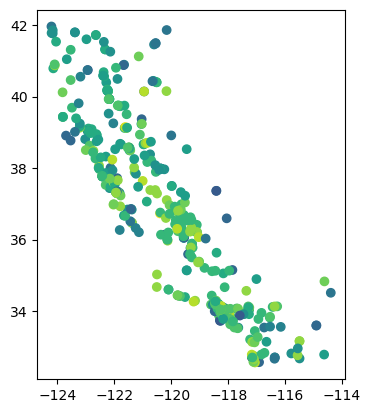

In [13]:
mental_healthcare_shortage_data.plot(column="HpsScore")

<Axes: >

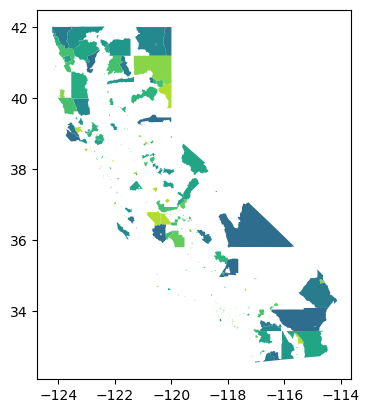

In [14]:
# sjoin with tracts
joined_mental_df = ca_tract_boundaries.sjoin(mental_healthcare_shortage_data).reset_index()
# take the mean of the point data within each tract
avg_mental_df = joined_mental_df.groupby('USCB_GEOID')['HpsScore'].agg(['mean']).reset_index()
# merge the means with the tract shapefile and transform to geodataframe so we can plot
avg_mental_df = avg_mental_df.rename(columns={"USCB_GEOID":"TRACT"})
avg_mental_df = pd.merge(avg_mental_df,ca_tract_boundaries,on="TRACT", how='right')
avg_mental_df = gpd.GeoDataFrame(avg_mental_df,geometry="geometry")
avg_mental_df.plot(column="mean")

In [15]:
columns_keep = ['TRACT', 'mean']

mental_healthcare_shortage_metric = avg_mental_df[columns_keep]
mental_healthcare_shortage_metric = mental_healthcare_shortage_metric.rename(columns={'TRACT':'census_tract', 'mean':'avg_hpsscore_mental_shortage_metric'})
mental_healthcare_shortage_metric

,census_tract,avg_hpsscore_mental_shortage_metric
0,06085504321,NaN
1,06085504410,NaN
2,06085507003,NaN
3,06085507004,NaN
4,06085502204,NaN
...,...,...
9124,06059001303,NaN
9125,06059001304,NaN
9126,06059001401,NaN
9127,06013367200,NaN


## Now to count the number of Indian Health Service designation types are in the mental healthcare shortage dataset
* per census tract
* then merge to our calculated metric dataframe based on tract

In [16]:
native_tribe_column = joined_mental_df

columns_to_keep = ['TRACT', 'HpsTypDes']

native_tribe_column = native_tribe_column[columns_to_keep]
native_tribe_merge = pd.merge(native_tribe_column,ca_tract_boundaries,on="TRACT", how='right')
cleaned_native_tribe = native_tribe_merge.drop_duplicates(subset=['TRACT', 'HpsTypDes'])

filtered_df = cleaned_native_tribe[cleaned_native_tribe['HpsTypDes'].isin(['Indian Health Service, Tribal Health, and Urban Indian Health Organizations'])]
mental_native_filtered = filtered_df[columns_to_keep]

grouped_native_counts = mental_native_filtered.groupby('TRACT')['HpsTypDes'].agg(['count']).reset_index()
grouped_native_counts_mental_shortage = grouped_native_counts.rename(columns={'TRACT':'census_tract'})
grouped_native_counts_mental_shortage

,census_tract,count
0,06001406100,1
1,06005000303,1
2,06005000402,1
3,06007000300,1
4,06007000403,1
...,...,...
92,06109003200,1
93,06109004102,1
94,06109005101,1
95,06113010902,1


In [17]:
# merge metric dataset to tribal healthcare sites
mental_healthcare_shortage_metric_tribe_count = pd.merge(grouped_native_counts_mental_shortage,
                                                        mental_healthcare_shortage_metric, 
                                                        on='census_tract',
                                                        how='right')

mental_healthcare_shortage_metric_tribe_count = mental_healthcare_shortage_metric_tribe_count.rename(columns={'count':'number_tribal_health_services'})

mental_healthcare_shortage_metric_tribe_count

,census_tract,number_tribal_health_services,avg_hpsscore_mental_shortage_metric
0,06085504321,NaN,NaN
1,06085504410,NaN,NaN
2,06085507003,NaN,NaN
3,06085507004,NaN,NaN
4,06085502204,NaN,NaN
...,...,...,...
9124,06059001303,NaN,NaN
9125,06059001304,NaN,NaN
9126,06059001401,NaN,NaN
9127,06013367200,NaN,NaN


In [18]:
# save as a csv
mental_healthcare_shortage_metric_tribe_count.to_csv('society_mental_healthcare_shortage_metric.csv', index=False)

## Function Call for both mental health and primary care shortages

In [19]:
@append_metadata
def healthcare_shortage_metric_calc(input_csv, export=False, varname=''):    
    '''
    Calculates the average Healthcare Professional Shortage Area (HPSA) score per California census tract.
    Data was sourced from: https://data.hrsa.gov/data/download
    The function calculates metrics for mental and primary healthcare shortages.

    The number of tribal health facilities were also retained and summed per census tract.

    Methods
    -------
    Data was cleaned by removing duplicate entries containing the same county and HPSA score.
    Data columns were renamed, merged to 2022 census tract data, and averaged to attribute
    scores to all California tracts.
    
    Parameters
    ----------
    df: string
        the dataframe containing the initial HPSA score data
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI HPSA score metric to AWS
        True = will upload resulting df containing CAL CRAI HPSA score metric to AWS
    import_csv: string
        name of the csv file to be uploaded to AWS

    Script
    ------
    society_healthcare_shortage.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are
    stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: data converted to Cal-CRAI standardized coordinate reference system (CRS): 4269.')
    print('Data transformation: merge data to California tracts and calculate census tract average.')
    print('Data transformation: nan values are retained for each census tract without an HPSA score.')

    bucket_name = 'ca-climate-index'
    directory = '3_fair_data/index_data'
    export_filename = [input_csv]

    if export == True:
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{export_filename} uploaded to AWS.')

    if os.path.exists(input_csv):
        os.remove(input_csv)

In [20]:
input_csv = ['society_primary_healthcare_shortage_metric.csv',
            'society_mental_healthcare_shortage_metric.csv']

varnames = [
    'society_hrsa_primary_care_shortage',
    'society_hrsa_mental_care_shortage']

for csv, var in zip(input_csv, varnames):
    healthcare_shortage_metric_calc(csv, export=True, varname=var)

### Narcotic Treatment Facilities Metric
* num. of licensed narcotic treatment programs per 10,000 people

In [21]:
narcotic_support_data = gpd.read_file('society_hrsa_narcotic_support.gpkg')
os.remove('society_hrsa_narcotic_support.gpkg')

In [22]:
narcotic_columns = ['OBJECTID',
                    'CountyName',
                    'DBA',
                    'OTP_CA10',
                    'geometry'
                    ]
narcotic_support = narcotic_support_data[narcotic_columns]
narcotic_support = narcotic_support.rename(columns={'CountyName': 'County'})

narcotic_support['County'] = narcotic_support['County'].str.replace(' County', '', case=False)

unique_entries = narcotic_support['County'].unique()

narcotic_support
unique_entries

array(['Alameda', 'Butte', 'Contra Costa', 'Fresno', 'Humboldt',
       'Imperial', 'Kern', 'Los Angeles', 'Marin', 'Merced', 'Monterey',
       'Mendocino', 'Orange', 'El Dorado', 'Placer', 'Riverside',
       'Sacramento', 'San Bernardino', 'San Diego', 'San Francisco',
       'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
       'Santa Clara', 'Santa Cruz', 'Solano', 'Sonoma', 'Tuolumne',
       'Shasta', 'Stanislaus', 'Nevada', 'Yuba', 'Tulare', 'Ventura',
       'Yolo'], dtype=object)

Checking to make sure only CA counties are included

In [23]:
ca_narcotic_support, omitted_rows = filter_counties(narcotic_support, 'County')
print(ca_narcotic_support)
print(f'number of omitted rows:{len(omitted_rows)}')

     OBJECTID   County                                  DBA OTP_CA10  \
0           1  Alameda                                  N/A     249M   
1           2  Alameda                                  N/A     309M   
2           3  Alameda               BAART Programs Oakland     186M   
3           4  Alameda               BAART Programs Oakland     186M   
4           5  Alameda  MedMark Treatment Centers - Hayward     304M   
..        ...      ...                                  ...      ...   
177       178  Ventura                                  N/A     298M   
178       179  Ventura                                  N/A     236M   
179       181  Ventura                                  N/A     386M   
180       182     Yolo                                  N/A     398M   
181       183  Ventura                                  N/A     174M   

                        geometry  
0    POINT (-121.88414 37.71620)  
1    POINT (-122.10225 37.68718)  
2    POINT (-122.24830 37.7912

Getting rid of duplicates based on a few columns

In [24]:
# Columns to check for duplicates
selected_columns = ['OTP_CA10', 'geometry', 'DBA']

# Check for duplicates
duplicates = ca_narcotic_support.duplicated(subset=selected_columns, keep=False)

# Count duplicates
duplicate_count = duplicates.sum()

# Filter out the duplicate rows for display
duplicate_rows = narcotic_support[duplicates]

print(f"Number of duplicate entries in columns {selected_columns}: {duplicate_count}")
print("Duplicate rows:")
display(duplicate_rows)

# Drop duplicates, keeping the first occurrence
narcotic_support_unique_values = narcotic_support.drop_duplicates(subset=selected_columns, keep='first')

Number of duplicate entries in columns ['OTP_CA10', 'geometry', 'DBA']: 16
Duplicate rows:


,OBJECTID,County,DBA,OTP_CA10,geometry
2,3,Alameda,BAART Programs Oakland,186M,POINT (-122.24830 37.79120)
3,4,Alameda,BAART Programs Oakland,186M,POINT (-122.24830 37.79120)
62,63,Los Angeles,BAART Programs Lynwood,205M,POINT (-118.18875 33.91724)
63,65,Los Angeles,BAART Programs Lynwood,205M,POINT (-118.18875 33.91724)
75,76,Los Angeles,BAART Programs Boyle Heights,279M,POINT (-118.21035 34.06239)
76,77,Los Angeles,BAART Programs Boyle Heights,279M,POINT (-118.21035 34.06239)
108,108,Sacramento,BAART Programs Carmicheal,293M,POINT (-121.32939 38.61252)
109,111,Sacramento,BAART Programs Carmicheal,293M,POINT (-121.32939 38.61252)
110,109,Sacramento,BAART Programs Norwood,274M,POINT (-121.45857 38.63813)
111,110,Sacramento,BAART Programs Norwood,274M,POINT (-121.45857 38.63813)


In [25]:
narcotic_support_unique_values

,OBJECTID,County,DBA,OTP_CA10,geometry
0,1,Alameda,N/A,249M,POINT (-121.88414 37.71620)
1,2,Alameda,N/A,309M,POINT (-122.10225 37.68718)
2,3,Alameda,BAART Programs Oakland,186M,POINT (-122.24830 37.79120)
4,5,Alameda,MedMark Treatment Centers - Hayward,304M,POINT (-122.08032 37.66542)
5,6,Alameda,N/A,354M,POINT (-122.16715 37.73928)
...,...,...,...,...,...
177,178,Ventura,N/A,298M,POINT (-119.06645 34.35216)
178,179,Ventura,N/A,236M,POINT (-118.78578 34.27040)
179,181,Ventura,N/A,386M,POINT (-119.22469 34.27695)
180,182,Yolo,N/A,398M,POINT (-121.57790 38.57071)


In [26]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_counties_tract = gpd.read_file(census_shp_dir)
ca_counties = ca_counties_tract.drop(columns={'field_1', 'TRACT', 'geometry'})

Merge narcotic support data with California counties

In [27]:
# Columns to check for duplicates
selected_columns = ['OTP_CA10', 'geometry', 'DBA']

merge_df = pd.merge(narcotic_support_unique_values, ca_counties, how='left', on='County')
merge_df = merge_df.drop_duplicates(subset=selected_columns, keep='first')
merge_df

,OBJECTID,County,DBA,OTP_CA10,geometry,COUNTYFP
0,1,Alameda,N/A,249M,POINT (-121.88414 37.71620),001
379,2,Alameda,N/A,309M,POINT (-122.10225 37.68718),001
758,3,Alameda,BAART Programs Oakland,186M,POINT (-122.24830 37.79120),001
1137,5,Alameda,MedMark Treatment Centers - Hayward,304M,POINT (-122.08032 37.66542),001
1516,6,Alameda,N/A,354M,POINT (-122.16715 37.73928),001
...,...,...,...,...,...,...
154958,178,Ventura,N/A,298M,POINT (-119.06645 34.35216),111
155148,179,Ventura,N/A,236M,POINT (-118.78578 34.27040),111
155338,181,Ventura,N/A,386M,POINT (-119.22469 34.27695),111
155528,182,Yolo,N/A,398M,POINT (-121.57790 38.57071),113


Make a new df containing counts of narcotic support facilities per California county

In [28]:
# Group by 'CntFips' and 'County' and count the number of entries
count_narcotic_support_facilities = merge_df.groupby(['COUNTYFP', 'County']).size().reset_index(name='num_narcotic_support_facilities')

print(len(count_narcotic_support_facilities))
count_narcotic_support_facilities

36


,COUNTYFP,County,num_narcotic_support_facilities
0,001,Alameda,8
1,007,Butte,1
2,013,Contra Costa,6
3,017,El Dorado,1
4,019,Fresno,8
5,023,Humboldt,1
6,025,Imperial,2
7,029,Kern,6
8,037,Los Angeles,48
9,041,Marin,1


In [29]:
# read in CA estimated county population
pull_county_pop = "s3://ca-climate-index/0_map_data/county_est_pop_2022.csv"
ca_county_pop = gpd.read_file(pull_county_pop)
ca_counties_pop = ca_county_pop.drop(columns={'field_1', 'geometry'})
ca_counties_pop = ca_counties_pop.rename(columns={'county':'County'})

In [30]:
# Ensure the 'num_narcotic_support_facilities' and 'est_total_pop' columns are numeric
count_narcotic_support_facilities['num_narcotic_support_facilities'] = pd.to_numeric(count_narcotic_support_facilities['num_narcotic_support_facilities'], errors='coerce')
ca_counties_pop['est_total_pop'] = pd.to_numeric(ca_counties_pop['est_total_pop'], errors='coerce')

ca_pop_narcotic_support_merge = pd.merge(ca_counties_pop, count_narcotic_support_facilities, on='County', how='right')
ca_pop_narcotic_support_merge['narcotic_support_per_10000'] = (ca_pop_narcotic_support_merge['num_narcotic_support_facilities'] / ca_pop_narcotic_support_merge['est_total_pop']) * 10000
ca_pop_narcotic_support_merge

,County,est_total_pop,COUNTYFP,num_narcotic_support_facilities,narcotic_support_per_10000
0,Alameda,1663823,001,8,0.048082
1,Butte,213605,007,1,0.046815
2,Contra Costa,1162648,013,6,0.051606
3,El Dorado,191713,017,1,0.052161
4,Fresno,1008280,019,8,0.079343
5,Humboldt,136132,023,1,0.073458
6,Imperial,179578,025,2,0.111372
7,Kern,906883,029,6,0.066161
8,Los Angeles,9936690,037,48,0.048306
9,Marin,260485,041,1,0.038390


In [31]:
ca_counties_tract

,field_1,TRACT,COUNTYFP,County,geometry
0,0,06085504321,085,Santa Clara,None
1,1,06085504410,085,Santa Clara,None
2,2,06085507003,085,Santa Clara,None
3,3,06085507004,085,Santa Clara,None
4,4,06085502204,085,Santa Clara,None
...,...,...,...,...,...
9124,9124,06059001303,059,Orange,None
9125,9125,06059001304,059,Orange,None
9126,9126,06059001401,059,Orange,None
9127,9127,06013367200,013,Contra Costa,None


In [32]:
ca_tracts = ca_counties_tract.drop(columns={'field_1', 'geometry', 'COUNTYFP'})
#count_narcotic_support_facilities = count_narcotic_support_facilities.drop(columns={'County'})

tract_merge = pd.merge(ca_tracts, ca_pop_narcotic_support_merge, on='County', how='left')
tract_merge

,TRACT,County,est_total_pop,COUNTYFP,num_narcotic_support_facilities,narcotic_support_per_10000
0,06085504321,Santa Clara,1916831.0,085,3.0,0.015651
1,06085504410,Santa Clara,1916831.0,085,3.0,0.015651
2,06085507003,Santa Clara,1916831.0,085,3.0,0.015651
3,06085507004,Santa Clara,1916831.0,085,3.0,0.015651
4,06085502204,Santa Clara,1916831.0,085,3.0,0.015651
...,...,...,...,...,...,...
9124,06059001303,Orange,3175227.0,059,6.0,0.018896
9125,06059001304,Orange,3175227.0,059,6.0,0.018896
9126,06059001401,Orange,3175227.0,059,6.0,0.018896
9127,06013367200,Contra Costa,1162648.0,013,6.0,0.051606


Function to check data per county

In [33]:
# Define a function to display data for a specific county
def display_county_data(df, county_name):
    county_data = df[df['County'] == county_name]
    if county_data.empty:
        print(f"No data found for {county_name}")
    else:
        print(f"Data for {county_name}:")
        display(county_data)

display_county_data(tract_merge, 'Orange')

Data for Orange:


,TRACT,County,est_total_pop,COUNTYFP,num_narcotic_support_facilities,narcotic_support_per_10000
55,06059062651,Orange,3175227.0,059,6.0,0.018896
56,06059062650,Orange,3175227.0,059,6.0,0.018896
57,06059062654,Orange,3175227.0,059,6.0,0.018896
58,06059052531,Orange,3175227.0,059,6.0,0.018896
59,06059052532,Orange,3175227.0,059,6.0,0.018896
...,...,...,...,...,...,...
9108,06059074102,Orange,3175227.0,059,6.0,0.018896
9109,06059074103,Orange,3175227.0,059,6.0,0.018896
9124,06059001303,Orange,3175227.0,059,6.0,0.018896
9125,06059001304,Orange,3175227.0,059,6.0,0.018896


## Function Call for Narcotic Support

In [34]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_counties_tract = gpd.read_file(census_shp_dir)
ca_counties_tract = ca_counties_tract.drop(columns={'field_1', 'geometry'})

@append_metadata
def narcotic_support_metric_calc(df, export=False, export_filename=None, varname=''):
    '''
    Calculates the number of Licensed Narcotic Treatment Programs per California county per
    10,000 people.
    Data was sourced from: https://data.chhs.ca.gov/dataset/licensed-narcotic-treatment-programs
    The function calculates the metrics for narcotic support.

    Methods
    -------
    Data was cleaned by removing duplicate entries containing the same location and facility identifier.
    Data columns were renamed, merged to 2022 census tract data, and summed to attribute scores to all 
    California tracts.
    
    Parameters
    ----------
    df: string
        the dataframe containing the initial narcotic support data
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI narcotic support metric to AWS
        True = will upload resulting df containing CAL CRAI narcotic support metric to AWS
    export_filename: string
        name of the csv file to be uploaded to AWS

    Script
    ------
    society_healthcare_shortage.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: isolate relevant columns and remove duplicate entries.')
    print('Data transformation: merge data to California counties and calculate county totals.')
    print('Data transformation: merge data to California tracts, keeping county sums for all tracts within.')
    print('Data transformation: import county population estimates and merge into data.')
    print('Data transformation: calculate metric by dividing county level narcotic treatment facilities by county population and multiply by 10,000.')

    # Columns to check for duplicates
    selected_columns = ['OTP_CA10', 'geometry', 'DBA']

    # Check for duplicates
    duplicates = df.duplicated(subset=selected_columns, keep=False)

    # Filter out the duplicate rows for display
    duplicate_rows = narcotic_support[duplicates]

    # Drop duplicates, keeping the first occurrence
    narcotic_support_unique_values = narcotic_support.drop_duplicates(subset=selected_columns, keep='first')

    # Columns to check for duplicates
    selected_columns = ['OTP_CA10', 'geometry', 'DBA']

    merge_df = pd.merge(narcotic_support_unique_values, ca_counties_tract, how='left', on='County')
    merge_df = merge_df.drop_duplicates(subset=selected_columns, keep='first')
    
    count_narcotic_support_facilities = merge_df.groupby(['COUNTYFP', 'County']).size().reset_index(name='num_narcotic_support_facilities')

    # read in CA estimated county population
    pull_county_pop = "s3://ca-climate-index/0_map_data/county_est_pop_2022.csv"
    ca_county_pop = gpd.read_file(pull_county_pop)
    ca_counties_pop = ca_county_pop.drop(columns={'field_1', 'geometry'})
    ca_counties_pop = ca_counties_pop.rename(columns={'county':'County'})

    # Ensure the 'num_narcotic_support_facilities' and 'est_total_pop' columns are numeric
    count_narcotic_support_facilities['num_narcotic_support_facilities'] =  pd.to_numeric(count_narcotic_support_facilities['num_narcotic_support_facilities'], errors='coerce')
    ca_counties_pop['est_total_pop'] = pd.to_numeric(ca_counties_pop['est_total_pop'], errors='coerce')

    ca_pop_narcotic_support_merge = pd.merge(ca_counties_pop, count_narcotic_support_facilities, on='County', how='right')
    ca_pop_narcotic_support_merge['narcotic_support_per_10000'] = (ca_pop_narcotic_support_merge['num_narcotic_support_facilities'] / ca_pop_narcotic_support_merge['est_total_pop']) * 10000

    ca_tracts = ca_counties_tract.drop(columns={'COUNTYFP'})
    
    tract_merge = pd.merge(ca_tracts, ca_pop_narcotic_support_merge, on='County', how='left')
    tract_merge = tract_merge.drop(columns='COUNTYFP')
    # export to csv and upload to AWS
    if export == True:
        tract_merge.to_csv(export_filename)
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [export_filename]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{export_filename} uploaded to AWS.')

    if os.path.exists(export_filename[0]):
        os.remove(export_filename[0])

    return tract_merge

In [35]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/society_economy/social_services/ca_health_human_services/'

pull_gpkg_from_directory(bucket_name, aws_dir)

narcotic_support_data = gpd.read_file('society_hrsa_narcotic_support.gpkg')

narcotic_columns = ['OBJECTID',
                    'CountyName',
                    'DBA',
                    'OTP_CA10',
                    'geometry'
                    ]
narcotic_support = narcotic_support_data[narcotic_columns]
narcotic_support = narcotic_support.rename(columns={'CountyName': 'County'})
narcotic_support['County'] = narcotic_support['County'].str.replace(' County', '', case=False)

narcotic_support_metric_calc(narcotic_support, export=True, export_filename='society_narcotic_support_metric.csv', varname='test')#'society_hrsa_narcotic_support')

Saved GeoPackage as 'society_hrsa_mental_care_shortage.gpkg' locally
Saved GeoPackage as 'society_hrsa_primary_care_shortage.gpkg' locally
Saved GeoPackage as 'society_hrsa_narcotic_support.gpkg' locally


,TRACT,County,est_total_pop,num_narcotic_support_facilities,narcotic_support_per_10000
0,06085504321,Santa Clara,1916831.0,3.0,0.015651
1,06085504410,Santa Clara,1916831.0,3.0,0.015651
2,06085507003,Santa Clara,1916831.0,3.0,0.015651
3,06085507004,Santa Clara,1916831.0,3.0,0.015651
4,06085502204,Santa Clara,1916831.0,3.0,0.015651
...,...,...,...,...,...
9124,06059001303,Orange,3175227.0,6.0,0.018896
9125,06059001304,Orange,3175227.0,6.0,0.018896
9126,06059001401,Orange,3175227.0,6.0,0.018896
9127,06013367200,Contra Costa,1162648.0,6.0,0.051606
